In [ ]:
from google.colab import auth
from datetime import datetime
import os
import numpy as np
import pandas as pd
from google.colab import drive
import torch
import torchaudio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import zipfile
import requests
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
!git clone https://github.com/PK1725/ssast_custom.git
!wget https://www.dropbox.com/s/ewrzpco95n9jdz6/SSAST-Base-Patch-400.pth?dl=1 -O SSAST-Base-Patch-400.pth

!pip install timm=="0.4.5"
from ssast_custom.src.models import ASTModel

# Import .wav file from Google Drive
#from google.colab import drive
drive.mount('/content/drive')

Cloning into 'ssast_custom'...
remote: Enumerating objects: 568, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 568 (delta 0), reused 0 (delta 0), pack-reused 563
Receiving objects: 100% (568/568), 11.99 MiB | 7.91 MiB/s, done.
Resolving deltas: 100% (331/331), done.
--2023-12-18 14:46:50--  https://www.dropbox.com/s/ewrzpco95n9jdz6/SSAST-Base-Patch-400.pth?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/ewrzpco95n9jdz6/SSAST-Base-Patch-400.pth [following]
--2023-12-18 14:46:51--  https://www.dropbox.com/s/dl/ewrzpco95n9jdz6/SSAST-Base-Patch-400.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc386d3b04ac45393abea8b70f17.dl.dropboxusercontent.com/cd/0/get/CJrH

In [ ]:

def wav2fbank(filename, filename2=None):
        # mixup
        if filename2 == None:
            waveform, sr = torchaudio.load(filename)
            waveform = waveform - waveform.mean()
        # mixup
        else:
            waveform1, sr = torchaudio.load(filename)
            waveform2, _ = torchaudio.load(filename2)

            waveform1 = waveform1 - waveform1.mean()
            waveform2 = waveform2 - waveform2.mean()

            if waveform1.shape[1] != waveform2.shape[1]:
                if waveform1.shape[1] > waveform2.shape[1]:
                    # padding
                    temp_wav = torch.zeros(1, waveform1.shape[1])
                    temp_wav[0, 0:waveform2.shape[1]] = waveform
                    waveform2 = temp_wav
                else:
                    # cutting
                    waveform2 = waveform2[0, 0:waveform1.shape[1]]

            # sample lambda from uniform distribution
            #mix_lambda = random.random()
            # sample lambda from beta distribtion
            mix_lambda = np.random.beta(10, 10)

            mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
            waveform = mix_waveform - mix_waveform.mean()

        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 1024
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]

        if filename2 == None:
            return fbank, 0
        else:
            return fbank, mix_lambda
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank
def display_fbank(bank, minmin=None, maxmax=None):
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')

In [ ]:
!pwd

/content


In [ ]:

# Create a new folder
drum_path = "drums"  # Adjust the path as needed
violin_path = "violins"  # Adjust the path as needed

# Create the folder if it doesn't exist
if not os.path.exists(drum_path):
    os.makedirs(drum_path)
# Create the folder if it doesn't exist
if not os.path.exists(violin_path):
    os.makedirs(violin_path)

# Your modified Dropbox link
url_drum = 'https://www.dropbox.com/scl/fo/ynvpkxxt8svyujbygjmhb/h?rlkey=dc5x0fe5baumy8h3oukydry0g&dl=1' #'https://www.dropbox.com/scl/fo/3r6y5rukigkeojz6rz3t8/h?rlkey=t8tkj85lepfql5vbjisq7a18n&dl=1'  # Replace with your modified link
url_violin = 'https://www.dropbox.com/scl/fo/ahxcyxzeesu496zbedoac/h?rlkey=tru7pweiz5sss90dow9l9n5gs&dl=1'#'https://www.dropbox.com/scl/fo/3zmoanvnhskd0st2zrqtz/h?rlkey=fkya4kg6ztos6akb5t8dbcheb&dl=1'  # Replace with your modified link

# Send a request to the URL
response = requests.get(url_drum)

# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(drum_path)
# Send a request to the URL
response = requests.get(url_violin)

# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(violin_path)

print("Download and extraction complete!")

Download and extraction complete!


In [ ]:
input_tdim = 1024  # fine-tuning data length can be different with pretraining data length
ast_mdl = ASTModel(label_dim=527,
             fshape=16, tshape=16, fstride=16, tstride=16,
             input_fdim=128, input_tdim=input_tdim, model_size='base',
             pretrain_stage=False, load_pretrained_mdl_path='SSAST-Base-Patch-400.pth')

now load a SSL pretrained models from SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=16, time=16
fine-tuning number of patches=512


In [ ]:
import random
def filter_wav_elements(input_list):
    return [element for element in input_list if element.endswith(".wav")]

# Generate representations
data_drums_path = 'drums'
data_violin_path = 'violins'

# List all files in the specified folder
data_drums = os.listdir(data_drums_path)
data_drums = filter_wav_elements(data_drums)
data_violin = os.listdir(data_violin_path)
data_violin = filter_wav_elements(data_violin)

min_data_length = np.min([len(data_drums),len(data_violin)])
song_indices = list(range(min_data_length))

n_test = 20

test_set_indices = random.sample(song_indices, n_test)


test_violin = [data_drums[i] for i in test_set_indices]
test_drums = [data_violin[i] for i in test_set_indices]
train_violin =[data_drums[i] for i in song_indices if i not in test_set_indices]
train_drums =[data_violin[i] for i in song_indices if i not in test_set_indices]





X = np.zeros((len(train_violin)+len(train_drums),768))
X_test = np.zeros((len(test_violin)+len(test_drums),768))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i,clip in enumerate(train_violin):
  fbank,_ = wav2fbank("violins/" + clip)
  fbank = fbank.to(device)
  x = fbank.unsqueeze(0)

  representation = ast_mdl(x,task='ft_avgtok').cpu().detach().numpy()
  X[i,:] = representation

for i,clip in enumerate(test_violin):
  fbank,_ = wav2fbank("violins/" + clip)
  fbank = fbank.to(device)
  x = fbank.unsqueeze(0)

  representation = ast_mdl(x,task='ft_avgtok').cpu().detach().numpy()
  X_test[i,:] = representation

for i,clip in enumerate(train_drums):
  fbank,_ = wav2fbank("drums/" + clip)
  fbank = fbank.to(device)
  x = fbank.unsqueeze(0)

  representation = ast_mdl(x,task='ft_avgtok').cpu().detach().numpy()
  X[i+len(train_violin),:] = representation

for i,clip in enumerate(test_drums):
  fbank,_ = wav2fbank("drums/" + clip)
  fbank = fbank.to(device)
  x = fbank.unsqueeze(0)

  representation = ast_mdl(x,task='ft_avgtok').cpu().detach().numpy()
  X_test[i+len(test_violin),:] = representation

y = np.concatenate((np.zeros(len(train_violin)), np.ones(len(train_drums))))
y_test = np.concatenate((np.zeros(len(test_violin)), np.ones(len(test_drums))))



In [ ]:
#clf = svm.SVC()
#clf = KNeighborsClassifier(n_neighbors=4)
clf = LogisticRegression(random_state=0)
clf.fit(X, y)
preds = clf.predict(X_test)
print(preds)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, preds)
print(acc)


[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.]
0.8


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import os
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# Concatenate the training and test data
X_combined = np.vstack((X, X_test))
# Calculate t-SNE embeddings for the combined data
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(X_combined)

# Separate the t-SNE embeddings for training and test data
tsne_train = tsne_embeddings[:len(X)]
tsne_test = tsne_embeddings[len(X):]


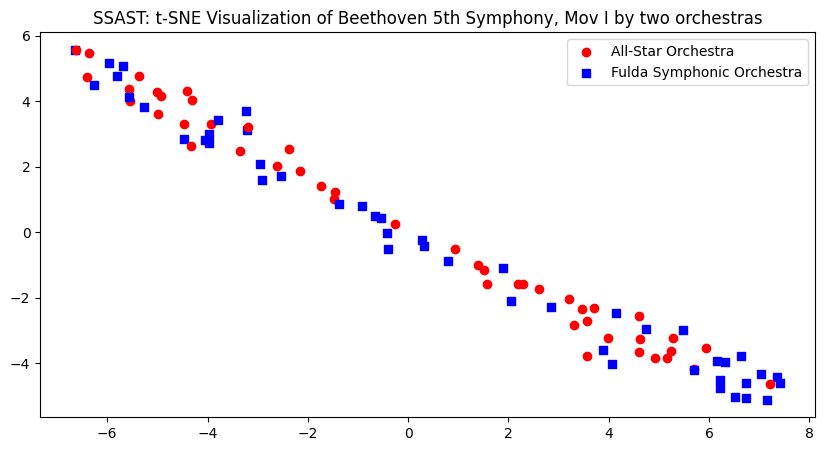

In [ ]:

# Create a scatter plot for training data
plt.figure(figsize=(10, 5))
plt.scatter(tsne_train[y == 0, 0], tsne_train[y == 0, 1], label='All-Star Orchestra', c='r', marker='o')
plt.scatter(tsne_train[y == 1, 0], tsne_train[y == 1, 1], label='Fulda Symphonic Orchestra', c='b', marker='s')


plt.scatter(tsne_test[y_test == 0, 0], tsne_test[y_test == 0, 1], c='r', marker='o')
plt.scatter(tsne_test[y_test == 1, 0], tsne_test[y_test == 1, 1], c='b', marker='s')

# Add labels and legend
plt.title('SSAST: t-SNE Visualization of Beethoven 5th Symphony, Mov I by two orchestras')
plt.legend()
# Show the plot
plt.show()
